# Gaussian Mixture Model

Before starting to program the expectation maximization algorithm, it is necessary to import some libraries that are used throughout this notebook.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

plotting = __name__=='__main__'

if plotting:
    import matplotlib.pyplot as plt
    from utils.helpers import (
        plot_dataset,
        plot_clusters,
        plot_classification_init,
        plot_classification_clusters,
        plot_classification
    )

### Generate dataset

Additionaly, we need to have some data points to which we can apply the model. The function below, `generate_dataset()`, is responsible for generating sample data. The function has two input parameters, namely `num_samples` and `num_clusters`. As their names suggest, these variables provide the desired amount of samples and clusters to the function. The function returns a numpy array containing the x and y coordinates of all the samples. You don't have to change anything to the code, but try to understand how the samples are generated.

In [2]:
def generate_dataset(num_samples, num_clusters):
    mean = 40 * (np.random.rand(num_clusters, 2) - 0.5)
    cov = 2 * (np.random.rand(num_clusters, 1) - 0.5)
    std = 10 * np.random.rand(num_clusters, 2)
    priors = np.random.rand(num_clusters, 1)
    priors = priors / np.sum(priors)
    priors = np.round(priors * num_samples).astype(int)
    samples = []

    for mu, sigma, prior, std in zip(mean, cov, priors, std):
        covariance = np.array([[std[0], 0], [0, std[1]]]) * np.array([[1, sigma[0]], [sigma[0], 1]]) * np.array([[std[0], 0], [0, std[1]]])
        cluster_data = np.random.multivariate_normal(mu, covariance, prior).T
        samples.append(cluster_data)
    samples = np.concatenate(samples, 1)
    return samples

Below you will find a small check to see if you understand the concept of the `generate_dataset()` function. Given that `N_SAMPLES` is equal to 5000 and `N_CLUSTERS` is equal to 10, what will be the shape of the numpy array containing the samples? If you have your answer, run the cell below to check if you where right.

In [3]:
np.random.seed(40)

# How many clusters
n_clusters = 10
n_samples = 5000

samples = generate_dataset(n_samples, n_clusters)

print(samples.shape)

(2, 5000)


### Initialization

Before starting with the expectation maximization algorithm, we have to set the number of iterations and initialize the means, covariances and priors for the clusters and membership probabilities for all samples

In [4]:
def init_data(samples, n_clusters=n_clusters, rand_idx=None):
    n_samples = samples.shape[1]
    
    # Set the mean for each cluster equal to the position of a random sample
    if rand_idx is None:
        rand_idx = np.random.randint(n_samples, size=(n_clusters))
    mean = samples[:, rand_idx].T

    # Initialize the covariance matrix
    covariance = 10 * np.tile(np.eye(2, 2), (n_clusters, 1, 1))

    # Initialize the priors
    priors = np.ones((n_clusters, 1))/n_clusters

    # Initialize the membership probabilities
    membership_prob = np.concatenate((np.ones((1, n_samples)), np.zeros((n_clusters-1, n_samples))))
    
    return mean, covariance, priors, membership_prob

In [5]:
mean, covariance, priors, membership_prob = init_data(samples)

print(mean.shape)
print(covariance.shape)
print(priors.shape)
print(membership_prob.shape)

(10, 2)
(10, 2, 2)
(10, 1)
(10, 5000)


### Plot dataset

Let's now plot the samples with the initial clusters. Running the code below will plot all the samples and clusters,

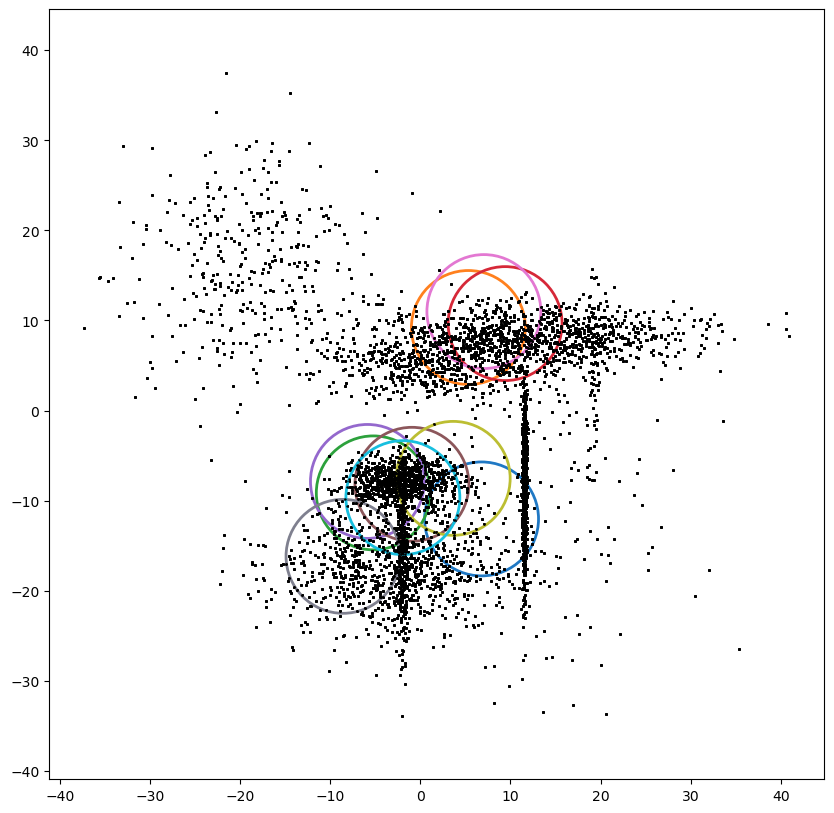

In [6]:
if plotting:
    plot_dataset(samples, mean, covariance)

#### Create a small testing sample with 2 clusters and 2 samples only to test on the following functions

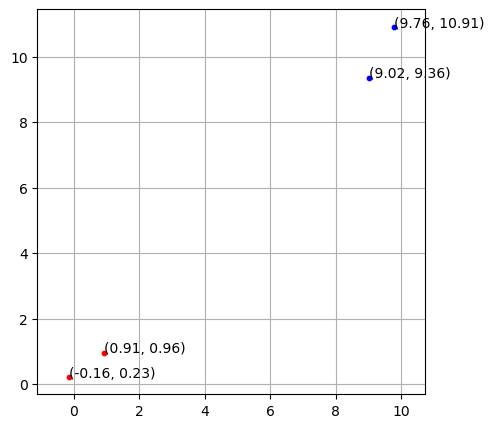

In [7]:
# testing sample size 
n_classes = 2
size = 2

# Give random samples from two clusters
mean_1 = [0, 0]
cov_1 = [[1, 0], [0, 1]]
samples_test_1 = np.random.multivariate_normal(mean_1, cov_1, size).T

mean_2 = [10, 10]
cov_2 = [[1, 0], [0, 1]]
samples_test_2 = np.random.multivariate_normal(mean_2, cov_2, size).T

# Concatenate the samples
samples_test = np.concatenate((samples_test_1, samples_test_2), 1)

# Plot the samples
if plotting:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    for i in range(samples_test.shape[1]):
        if i < size: plt.scatter(samples_test[0][i], samples_test[1][i], s=10, c='red')
        else: plt.scatter(samples_test[0][i], samples_test[1][i], s=10, c='blue')
        plt.text(samples_test[0][i], samples_test[1][i], \
            '({}, {})'.format(round(samples_test[0][i], 2), round(samples_test[1][i], 2)))
    plt.axis('equal')
    plt.grid()
    plt.show()

# Initialize the mean matrix
mean_test = np.array([[5, 5], [5, 5]])

# Initialize the covariance matrix
covariance_test = np.array([[[10., 0.], [0., 10.]], [[10., 0.], [0., 10.]]])

# Initialize the priors
priors_test = np.array([[0.3], [0.7]])

# Initialize the membership probabilities
membership_prob_test = np.concatenate((np.repeat(0.5, size*n_classes), \
    np.repeat(0.5, size*n_classes))).reshape(n_classes, size*n_classes)

### Expectation maximization

It is now time to start with the implementation of the Expectation Maximization algorithm. To do so we are going to create separate functions for all the steps in the algorithm. When all these steps have been implemented, they will be combined and put inside of a loop which runs `MAX_ITERS` times. In the cell below, provide the implementation of the expectation step.

HINT: You can use the `multivariate_normal.pdf()` function to create a multivariate normal distribution. Documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html).

$$
w_{i,n} = \frac{Prior_i N(sample_n | \mu_i , \Sigma _i))}{\sum_{j=1}^{I}Prior_j N(sample_n | \mu_j ,\Sigma _j))}
$$

In [8]:
def expectation(samples, mean, covariance, priors, membership_prob, num_clusters):
    
    for i in range(num_clusters):
        membership_prob[i,:]=priors[i] * multivariate_normal.pdf(samples.T, mean=mean[i], cov=covariance[i])
        
    membership_prob /= membership_prob.sum(axis=0, keepdims=True)
    
        
    return membership_prob

expectation(samples_test, mean_test, covariance_test, priors_test, membership_prob_test, n_classes)

array([[0.3, 0.3, 0.3, 0.3],
       [0.7, 0.7, 0.7, 0.7]])

The maximization step can be separated in three components, the computation of the priors, the computation of the means and the computation of the covariances. Below you will find the structure of the functions which you will have to fill in yourself.

$$
Prior_i = \frac{\sum_{n=1}^{N}{w_{i,n}}}{N}
$$

In [9]:
def compute_priors(priors, membership_prob, num_clusters, num_samples):
    
    sum = membership_prob.sum(axis = 1)
    priors = sum/num_samples
    priors = np.reshape(priors, (num_clusters,1))
    return priors

compute_priors(priors_test, membership_prob_test, n_classes, size*n_classes).shape

(2, 1)

$$ mean_i = \frac{\sum_{n=1}^{N}{w_{i,n}} . sample_n}{\sum_{n=1}^{N}{w_{i,n}}} $$

In [10]:
def compute_mean(samples, mean, priors, membership_prob, num_clusters, num_samples):
    
    sum = membership_prob.sum(axis = 1)
    mean = np.matmul(membership_prob, samples.T)
    mean /=sum[:, None]
    return mean

compute_mean(samples_test, mean_test, priors_test, membership_prob_test, n_classes, size*n_classes)

array([[4.88408097, 5.36433584],
       [4.88408097, 5.36433584]])

$$ 
cov_i = \frac{\sum_{n=1}^{N}{w_{i,n}} (sample_n - \mu_i)(sample_n - \mu_i)^T }{\sum_{n=1}^{N}{w_{i,n}}}
$$

In [11]:
def compute_covariance(samples, mean, covariance, priors, membership_prob, num_clusters, num_samples):
    
    samples=samples.T
    membership_prob=membership_prob.T
    
    sum_z = membership_prob.sum(axis = 0)
    for i in range(num_clusters):
        j = np.expand_dims(samples, axis=1) - mean[i]
        s = np.matmul(j.transpose([0, 2, 1]), j)
        covariance[i] = np.matmul(s.transpose(1, 2, 0), membership_prob[:, i] )
        covariance[i] /= sum_z[i]
    
    samples=samples.T
    membership_prob=membership_prob.T
    #covariance=covariance.T
    
    return covariance

compute_covariance(samples_test, mean_test, covariance_test, priors_test, membership_prob_test, n_classes, size*n_classes)

array([[[20.52103305, 21.69471471],
        [21.69471471, 23.26624509]],

       [[20.52103305, 21.69471471],
        [21.69471471, 23.26624509]]])

Now that all parts of the expectation maximization algorithm have been implemented, they should be combined. The cell below contains the outline of a function in which all the above functions should be combined in the correct order.

In [12]:
def expectation_maximization(samples, mean, covariance, priors, membership_prob, num_clusters, num_samples):
    # Combine the fuctions defined above
    
    membership_prob = expectation(samples, mean, covariance, priors, membership_prob, num_clusters)
    priors = compute_priors(priors, membership_prob, num_clusters, num_samples)
    mean = compute_mean(samples, mean, priors, membership_prob, num_clusters, num_samples)
    covariance = compute_covariance(samples, mean, covariance, priors, membership_prob, num_clusters, num_samples)
    return covariance, priors, mean, membership_prob

In [13]:
# call the function to see if it works
covariance_update, priors_update, mean_update, membership_prob_update = \
    expectation_maximization(samples_test, mean_test, covariance_test, priors_test, 
                            membership_prob_test, n_classes, size*n_classes)
    
print("Updated covariance = \n", covariance_update)
print("\n Updated priors = \n", priors_update)
print("\n Updated mean = \n", mean_update)
print("\n Updated membership probabilities = \n", membership_prob_update)

Updated covariance = 
 [[[20.50759583 21.73694816]
  [21.73694816 23.13350448]]

 [[20.50759583 21.73694816]
  [21.73694816 23.13350448]]]

 Updated priors = 
 [[0.3]
 [0.7]]

 Updated mean = 
 [[4.88408097 5.36433584]
 [4.88408097 5.36433584]]

 Updated membership probabilities = 
 [[0.3 0.3 0.3 0.3]
 [0.7 0.7 0.7 0.7]]


The function that executes the expectation maximization algorithm can now be used. The cell below uses this function and runs the algorithm `MAX_ITERS` times. The resulting clusters are plotted below the cell.

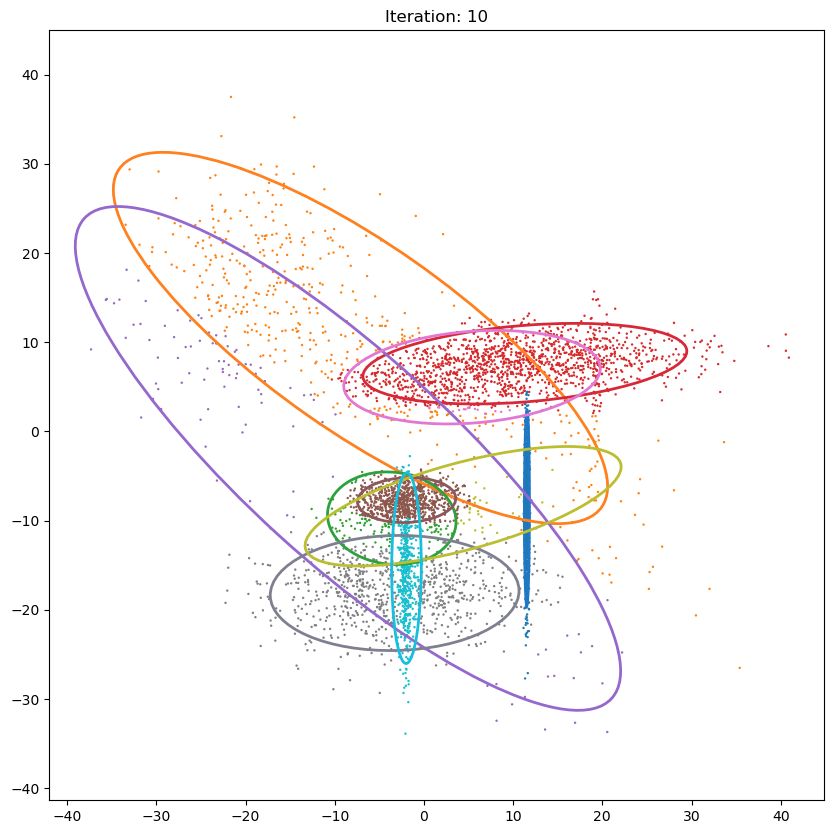

In [14]:
def expectation_maximization_clustering(samples, mean, covariance, priors, membership_prob,
                                        n_clusters=n_clusters, n_samples=n_samples, max_iters=10):
    for i in range(max_iters):
        # Execute the expectation maximization function
        covariance, priors, mean, membership_prob = \
            expectation_maximization(samples, mean, covariance, priors, membership_prob, n_clusters, n_samples)

        # Classify points
        cluster = np.argmax(membership_prob, axis=0).astype(int)

        # Plot
        if plotting:
            plot_clusters(cluster, samples, mean, covariance, i)
        
expectation_maximization_clustering(samples, mean, covariance, priors, membership_prob)

## Classification using expectation maximization

The expectation maximization can also be used to classify new samples. The remainder of this assignment will focus on implementing the algorithm, such that new samples can be classified. To start, a new dataset will be created. This dataset consists of two classes, hence two sets of samples will be created.

In [15]:
def generate_classification_dataset():
    angles = np.arange(-np.pi, np.pi, 0.01)
    radius = np.arange(10/angles.shape[0], 10, 10/angles.shape[0])
    
    c1 = np.array([np.cos(angles) * radius, np.sin(angles) * radius])
    samples_c1 = c1 + np.random.randn(2, c1.shape[1])/2
    samples_c1 = np.concatenate((samples_c1, c1 + np.random.randn(2, c1.shape[1])/2), axis=1)
    samples_c1 = np.concatenate((samples_c1, c1 + np.random.randn(2, c1.shape[1])/2), axis=1)

    c2 = np.array([np.cos(angles) * (radius + 2), np.sin(angles) * (radius + 2)])
    samples_c2 = c2 + np.random.randn(2, c2.shape[1])/2
    samples_c2 = np.concatenate((samples_c2, c2 + np.random.randn(2, c2.shape[1])/2), axis=1)
    samples_c2 = np.concatenate((samples_c2, c2 + np.random.randn(2, c2.shape[1])/2), axis=1)
    return samples_c1, samples_c2

Again, we have to set and initialize some values. We set the number of iterations and the number of clusters per class. Additionally, the means, covariances, prios and the membership probabilities are initialized for both classes.

In [16]:
def initialize_classification():
    np.random.seed(2)

    n_clusters = 10
    
    # Generate a random dataset
    samples_c1, samples_c2 = generate_classification_dataset()
    n_samples = samples_c1.shape[1]

    # Choose initial values
    rand_idx = np.random.randint(n_samples, size=(n_clusters))
    
    # For class 1
    mean_c1, covariance_c1, priors_c1, membership_prob_c1 = init_data(samples_c1, rand_idx=rand_idx)

    # For class 2
    mean_c2, covariance_c2, priors_c2, membership_prob_c2 = init_data(samples_c2, rand_idx=rand_idx)

    covariance_c1 /= 5
    covariance_c2 /= 5

    return samples_c1, mean_c1, covariance_c1, priors_c1, membership_prob_c1, \
        samples_c2, mean_c2, covariance_c2, priors_c2, membership_prob_c2

We can now display the samples with the initial clusters.

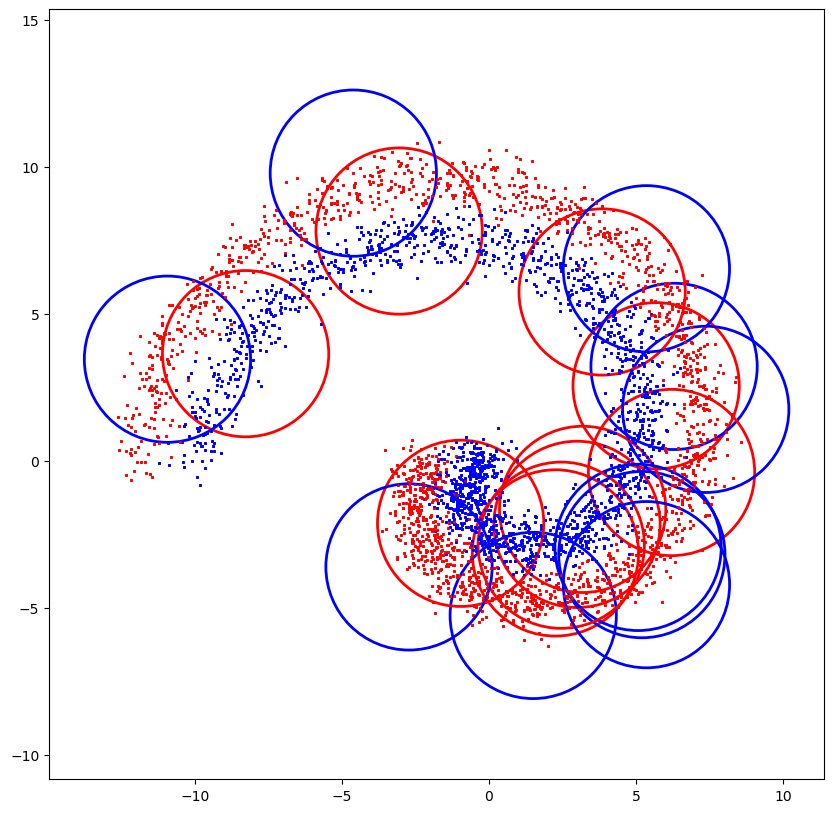

In [17]:
samples_c1, mean_c1, covariance_c1, priors_c1, membership_prob_c1, \
    samples_c2, mean_c2, covariance_c2, priors_c2, membership_prob_c2 = initialize_classification()

if plotting:
    plot_classification_init(samples_c1, mean_c1, covariance_c1, samples_c2, mean_c2, covariance_c2)

In order to correctly classify new samples, we have to apply the expectation maximization algorithm on both classes. This can be done using the same function as earlier.

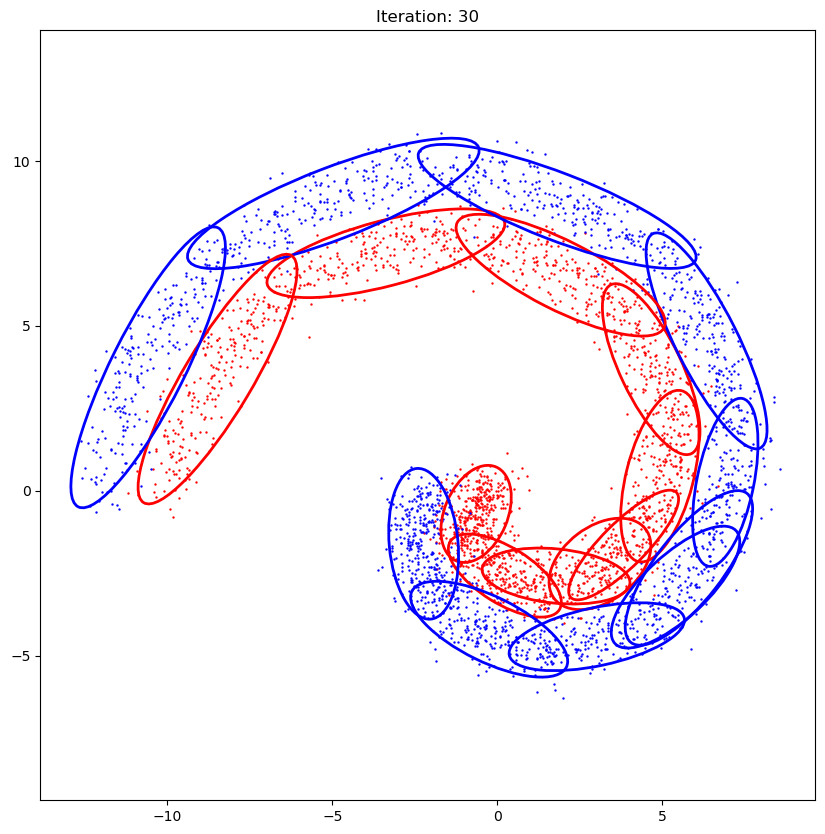

In [18]:
# How many iterations
max_iters = 30
n_samples = samples_c1.shape[1]
for i in range(max_iters):
    # Execute the expectation maximization function
    covariance_c1, priors_c1, mean_c1, membership_prob_c1 = \
        expectation_maximization(samples_c1, mean_c1, covariance_c1, priors_c1, membership_prob_c1, n_clusters, n_samples)
    covariance_c2, priors_c2, mean_c2, membership_prob_c2 = \
        expectation_maximization(samples_c2, mean_c2, covariance_c2, priors_c2, membership_prob_c2, n_clusters, n_samples)
    if plotting:
        plot_classification_clusters(mean_c1, covariance_c1, samples_c1, mean_c2, covariance_c2, samples_c2, i)

Now that the expectation maximization algorithm has been implemented, we can classify new samples. To do this we create a function which calculates the probability of each class with respect to each cluster.


In [19]:
def compute_probability(samples, mean, covariance, priors, membership_prob, num_clusters=n_clusters):
    # computing the probability of each sample w.r.t. each cluster here
    for i in range(num_clusters):
        membership_prob[i,:]=priors[i] * multivariate_normal.pdf(samples.T, mean=mean[i], cov=covariance[i])
        
    #membership_prob *= membership_prob.sum(axis=0, keepdims=True)
    
    return membership_prob

This function is now used to predict the class of new samples. The samples are then plotted with the color of the corresponding class.

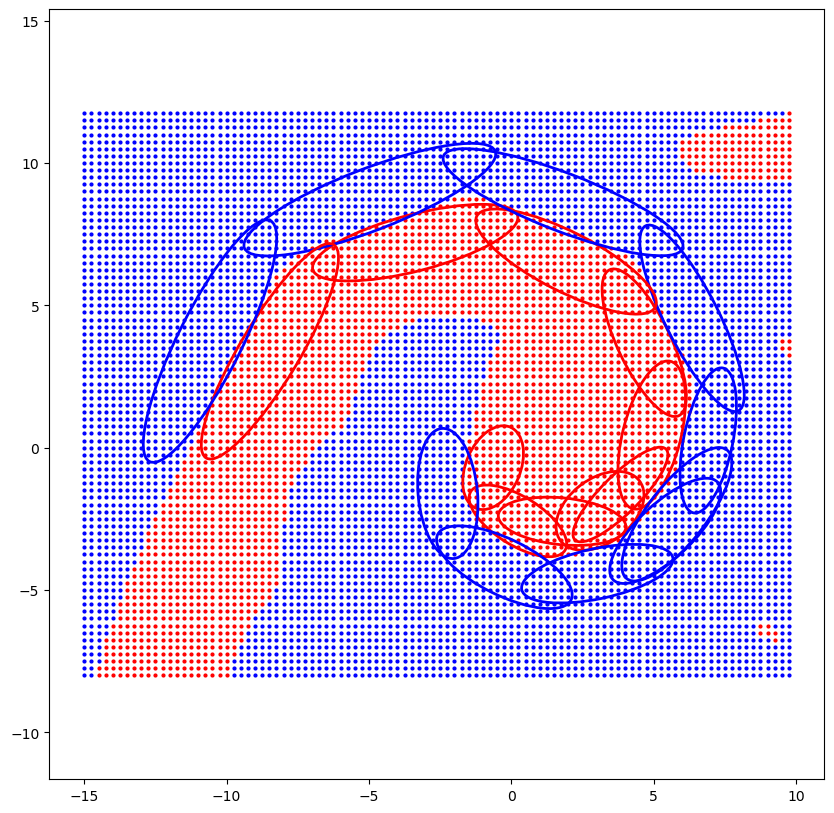

In [20]:
x, y = np.meshgrid(np.arange(-15, 10, 0.25), np.arange(-8, 12, 0.25))
x = x.flatten()
y = y.flatten()
samples_classification = np.array([x, y])

n_samples_classification = samples_classification.shape[1]

w_c1 = np.zeros((n_clusters, n_samples_classification))
w_c2 = np.zeros((n_clusters, n_samples_classification))

# Compute probability of each sample wrt each cluster
w_c1 = compute_probability(samples_classification, mean_c1, covariance_c1, priors_c1, w_c1)
w_c2 = compute_probability(samples_classification, mean_c2, covariance_c2, priors_c2, w_c2)

mx_c1 = np.sum(w_c1, axis=0)
mx_c2 = np.sum(w_c2, axis=0)
class_ = np.argmax(np.array([mx_c1, mx_c2]), axis=0)

if plotting:
    plot_classification(mean_c1, covariance_c1, mean_c2, covariance_c2, class_, samples_classification)